In [1]:
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("Tensorflow version: ", tf.__version__)
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import re
import pickle
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

Tensorflow version:  2.1.0


In [20]:
# Path to the data directory
data_dir = Path("D:\E\Python\captcha_images_v2")
#Get list of all the images
images = list(data_dir.glob("*.png"))
# Store all the characters in a set
characters = set()

# A list to store the length of each captcha
captcha_length = []

# Store image-label info
dataset = []

# Iterate over the dataset and store the
# information needed
for img_path in images:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this cpatcha
    captcha_length.append(len(label))
    # 3. Store the image-label pair info
    dataset.append((str(img_path), label))
    
    # 4. Store the characters present
    for ch in label:
        characters.add(ch)

# Sort the characters        
characters = sorted(characters)

# Convert the dataset info into a dataframe
dataset = pd.DataFrame(dataset, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset = dataset.sample(frac=1.).reset_index(drop=True)


#print("Number of unqiue charcaters in the whole dataset: ", len(characters))
#print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
#print("Characters present: ", characters)
##dataset.head()


In [21]:
# Split the dataset into training and validation sets
#training_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=seed)

training_data = dataset
#validation_data = validation_data.reset_index(drop=True)

#print("Number of training samples: ", len(training_data))
#print("Number of validation samples: ", len(validation_data))



# Map text to numeric labels 
char_to_labels = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
labels_to_char = {val:key for key, val in char_to_labels.items()}



# Sanity check for corrupted images
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters:
            return False
    return True



# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, resize=True, img_height=50, img_width=200):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images = np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)



# Build training data
training_data, training_labels = generate_arrays(df=training_data)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)


# Build validation data
#validation_data, validation_labels = generate_arrays(df=validation_data)
#print("Number of validation images: ", validation_data.shape)
#print("Number of validation labels: ", validation_labels.shape)
row_to_be_added = np.array(np.ones(200)) 
train_data=np.zeros(shape=(1021,200,200), dtype=np.float32)
for j in range(1021):
    result=training_data[j]
    for i in range(150):
# Adding row to numpy array 
        result = np.vstack ((result, row_to_be_added) ) 
    train_data[j]=result
    
#valid_data=np.zeros(shape=(103,200,200), dtype=np.float32)
#for j in range(103):
  #  result=validation_data[j]
   # for i in range(150):
# Adding row to numpy array 
    #    result = np.vstack ((result, row_to_be_added) ) 
   # valid_data[j]=result#
# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = "<go> "  
    
    # traverse in the string   
    for ele in s:  
        str1 += ele   
        str1 += " "
    # return string   
    return str1+ '<stop>'  
# Python3 program to Split string into characters 
def split(word): 
    return [char for char in word] 
train_labl_result=[0]*1021
#valed_labl_result=[0]*103
for i in range(1021):
    train_labl_result[i]=listToString(split(training_labels[i]))
#for i in range(103):
 #   valed_labl_result[i]=listToString(split(validation_labels[i]))
# Driver code 
#word = validation_labels[0]
#print(split(word)) 
 

Number of training images:  (1021, 50, 200)
Number of training labels:  (1021,)


In [22]:
oov_token = '<unk>'
document_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
document_tokenizer.fit_on_texts(train_labl_result)
targets = document_tokenizer.texts_to_sequences(train_labl_result)
targets = tf.cast(targets, dtype=tf.float32)
targets


<tf.Tensor: shape=(1021, 7), dtype=float32, numpy=
array([[ 2., 18.,  4., ..., 12.,  8.,  3.],
       [ 2., 11.,  4., ..., 13., 13.,  3.],
       [ 2.,  7., 12., ..., 12.,  7.,  3.],
       ...,
       [ 2.,  4.,  7., ..., 19., 10.,  3.],
       [ 2., 20., 10., ...,  6., 18.,  3.],
       [ 2., 14.,  7., ...,  4., 20.,  3.]], dtype=float32)>

In [59]:
len(characters)

19

In [21]:
BUFFER_SIZE = 1021
BATCH_SIZE = 16
dataset = tf.data.Dataset.from_tensor_slices((hg, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#print(dataset.shape)

In [7]:
encoder_vocab_size = 400
decoder_vocab_size = 100


In [8]:
#for i in range(1021):
  #  h=train_data[i].T
#h,train_data[0]
h=np.zeros(shape=(1021,200,200), dtype=np.float32)
for j in range(1021):
    h[j]=train_data[j].T
   # for i in range(150):
# Adding row to numpy array 
    #result = np.vstack ((result, row_to_be_added) ) 
   # train_data[j]=result
hg=np.concatenate((h, train_data), axis=1)

NameError: name 'train_data' is not defined

In [11]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(1000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates
  
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)
def positional_encoding_2(position, d_model):
  angle_rads = get_angles(np.arange(position/2)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
  pe2= pos_encoding.T 
  pe2=np.reshape(pe2,(1,200,200))
  pe2=np.concatenate((pe2, pos_encoding), axis=1)
  return tf.cast(pe2, dtype=tf.float32)

In [2]:

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
       
        
       
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
      
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights 

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


In [3]:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.InputLayer(input_shape=(input_vocab_size,d_model))
        #self.dense=tf.keras.layers.Dense(d_model)
        self.pos_encoding = positional_encoding_2(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
       
        x = self.embedding(x)
       # x=self.dense(x)
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        
        x += self.pos_encoding[:, :seq_len, :]
      

       
        
        #f=self.enc_layers[1](f, training, mask)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights
#Finally, the Transformer

class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [5]:
# hyper-params
num_layers = 3
d_model = 200
dff = 400
num_heads = 10
EPOCHS = 5
###########################
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
#######################
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


In [12]:
############################################
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
####################################################
train_loss = tf.keras.metrics.Mean(name='train_loss')
#########################
transformer66 = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    25, 
    pe_input=encoder_vocab_size, 
    pe_target=7,
)


In [27]:
####################mask
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask
###########################checkpoint
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer66, optimizer=optimizer)

ckpt_manager  = tf.train.CheckpointManager(
    ckpt, directory="New folder (3)", max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')


Latest checkpoint restored!!


In [134]:
    
#################################training step
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer66(
            inp, tar_inp, 
            True, 
            None, 
            combined_mask, 
            None
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer66.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer66.trainable_variables))

    train_loss(loss)


In [154]:
for epoch in range(10):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        # 55k samples
        # we display 3 batch results -- 0th, middle and last one (approx)
        # 55k / 64 ~ 858; 858 / 2 = 429
        #if batch % 50 == 0:
        print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, train_loss.result()))
      
    #if (epoch + 1) % 2 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
    
    print ('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 0.3000
Epoch 1 Batch 1 Loss 0.2631
Epoch 1 Batch 2 Loss 0.2363
Epoch 1 Batch 3 Loss 0.2495
Epoch 1 Batch 4 Loss 0.2450
Epoch 1 Batch 5 Loss 0.2505
Epoch 1 Batch 6 Loss 0.2522
Epoch 1 Batch 7 Loss 0.2387
Epoch 1 Batch 8 Loss 0.2377
Epoch 1 Batch 9 Loss 0.2295
Epoch 1 Batch 10 Loss 0.2344
Epoch 1 Batch 11 Loss 0.2293
Epoch 1 Batch 12 Loss 0.2224
Epoch 1 Batch 13 Loss 0.2161
Epoch 1 Batch 14 Loss 0.2292
Epoch 1 Batch 15 Loss 0.2226
Epoch 1 Batch 16 Loss 0.2185
Epoch 1 Batch 17 Loss 0.2245
Epoch 1 Batch 18 Loss 0.2230
Epoch 1 Batch 19 Loss 0.2220
Epoch 1 Batch 20 Loss 0.2212
Epoch 1 Batch 21 Loss 0.2381
Epoch 1 Batch 22 Loss 0.2424
Epoch 1 Batch 23 Loss 0.2502
Epoch 1 Batch 24 Loss 0.2506
Epoch 1 Batch 25 Loss 0.2497
Epoch 1 Batch 26 Loss 0.2470
Epoch 1 Batch 27 Loss 0.2584
Epoch 1 Batch 28 Loss 0.2565
Epoch 1 Batch 29 Loss 0.2559
Epoch 1 Batch 30 Loss 0.2543
Epoch 1 Batch 31 Loss 0.2559
Epoch 1 Batch 32 Loss 0.2555
Epoch 1 Batch 33 Loss 0.2611
Epoch 1 Batch 34 Loss 0.

KeyboardInterrupt: 

In [53]:
# Path to the data directory
data_dir = Path("E:\Local Disk F_122120182042\Python\\New folder (2)")
#Get list of all the images
images1 = list(data_dir.glob("*.png"))
# Store all the characters in a set
characters1 = set()

# A list to store the length of each captcha
captcha_length1 = []

# Store image-label info
dataset1 = []

# Iterate over the dataset and store the
# information needed
for img_path in images1:
    # 1. Get the label associated with each image
    label = img_path.name.split(".png")[0]
    # 2. Store the length of this cpatcha
    captcha_length1.append(len(label))
    # 3. Store the image-label pair info
    dataset1.append((str(img_path), label))
    
    # 4. Store the characters present
    for ch in label:
        characters1.add(ch)

# Sort the characters        
characters1 = sorted(characters1)

# Convert the dataset info into a dataframe
dataset1 = pd.DataFrame(dataset1, columns=["img_path", "label"], index=None)

# Shuffle the dataset
dataset1 = dataset1.sample(frac=1.).reset_index(drop=True)


#print("Number of unqiue charcaters in the whole dataset: ", len(characters))
#print("Maximum length of any captcha: ", max(Counter(captcha_length).keys()))
#print("Characters present: ", characters)
##dataset.head()


In [54]:
# Split the dataset into training and validation sets
#training_data, validation_data = train_test_split(dataset, test_size=0.1, random_state=seed)

training_data1 = dataset1
#validation_data = validation_data.reset_index(drop=True)

#print("Number of training samples: ", len(training_data))
#print("Number of validation samples: ", len(validation_data))



# Map text to numeric labels 
char_to_labels1 = {char:idx for idx, char in enumerate(characters1)}

# Map numeric labels to text
labels_to_char1 = {val:key for key, val in char_to_labels1.items()}



# Sanity check for corrupted images
def is_valid_captcha(captcha):
    for ch in captcha:
        if not ch in characters1:
            return False
    return True



# Store arrays in memory as it's not a muvh big dataset
def generate_arrays(df, resize=True, img_height=50, img_width=200):
    """Generates image array and labels array from a dataframe.
    
    Args:
        df: dataframe from which we want to read the data
        resize (bool)    : whether to resize images or not
        img_weidth (int): width of the resized images
        img_height (int): height of the resized images
        
    Returns:
        images (ndarray): grayscale images
        labels (ndarray): corresponding encoded labels
    """
    
    num_items = len(df)
    images= np.zeros((num_items, img_height, img_width), dtype=np.float32)
    labels = [0]*num_items
    
    for i in range(num_items):
        img = cv2.imread(df["img_path"][i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        if resize: 
            img = cv2.resize(img, (img_width, img_height))
        
        img = (img/255.).astype(np.float32)
        label = df["label"][i]
        
        # Add only if it is a valid captcha
        if is_valid_captcha(label):
            images[i, :, :] = img
            labels[i] = label
    
    return images, np.array(labels)



# Build training data
training_data1, training_labels1 = generate_arrays(df=training_data1)
print("Number of training images: ", training_data1.shape)
print("Number of training labels: ", training_labels1.shape)


# Build validation data
#validation_data, validation_labels = generate_arrays(df=validation_data)
#print("Number of validation images: ", validation_data.shape)
#print("Number of validation labels: ", validation_labels.shape)
row_to_be_added = np.array(np.ones(200)) 
train_data=np.zeros(shape=(3,200,200), dtype=np.float32)
for j in range(3):
    result=training_data1[j]
    for i in range(150):
# Adding row to numpy array 
        result = np.vstack ((result, row_to_be_added) ) 
    train_data[j]=result
    
#valid_data=np.zeros(shape=(103,200,200), dtype=np.float32)
#for j in range(103):
  #  result=validation_data[j]
   # for i in range(150):
# Adding row to numpy array 
    #    result = np.vstack ((result, row_to_be_added) ) 
   # valid_data[j]=result#
# Function to convert   
def listToString(s):  
    
    # initialize an empty string 
    str1 = "<go> "  
    
    # traverse in the string   
    for ele in s:  
        str1 += ele   
        str1 += " "
    # return string   
    return str1+ '<stop>'  
# Python3 program to Split string into characters 
def split(word): 
    return [char for char in word] 
train_labl_result=[0]*3
#valed_labl_result=[0]*103
for i in range(3):
    train_labl_result[i]=listToString(split(training_labels1[i]))
#for i in range(103):
 #   valed_labl_result[i]=listToString(split(validation_labels[i]))
# Driver code 
#word = validation_labels[0]
#print(split(word)) 
 

Number of training images:  (3, 50, 200)
Number of training labels:  (3,)


In [55]:
#for i in range(1021):
  #  h=train_data[i].T
#h,train_data[0]
h=np.zeros(shape=(3,200,200), dtype=np.float32)
for j in range(3):
    h[j]=train_data[j].T
   # for i in range(150):
# Adding row to numpy array 
    #result = np.vstack ((result, row_to_be_added) ) 
   # train_data[j]=result
hg=np.concatenate((h, train_data), axis=1)

In [28]:
hg.shape

(19, 400, 200)

In [28]:
def evaluate(input_img):
    #input_document = document_tokenizer.texts_to_sequences([input_document])
    #input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')
    encoder_input = input_img
    encoder_input = tf.expand_dims(encoder_input, 0)

    decoder_input = tf.cast([2.], dtype=tf.float32)
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(7):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions,_ = transformer66(
            encoder_input, 
            output,
            False,
            None,
            combined_mask,
            None
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.float32)

        if predicted_id == [3.]:
            return tf.squeeze(output, axis=0)

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [29]:
def summarize(input_img):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_img)
    summarized = np.expand_dims(summarized[1:], 0)  # not printing <go> token
    return document_tokenizer.sequences_to_texts(summarized)[0] # since there is just one translated document

In [56]:
for i in range(3):
    print(training_labels1[i]),print(summarize(hg[i]))

5
w 2 n 7 w
1
3 3 3 m x
4
4 4 c n 7


In [41]:
summarize(hg[16])

'e p p g 8'

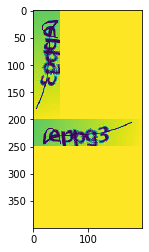

In [42]:
plt.imshow(hg[16])

In [153]:
transformer66.summary()

Model: "transformer_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_12 (Encoder)         multiple                  966600    
_________________________________________________________________
decoder_11 (Decoder)         multiple                  1455200   
_________________________________________________________________
dense_507 (Dense)            multiple                  5025      
Total params: 2,426,825
Trainable params: 2,426,825
Non-trainable params: 0
_________________________________________________________________


In [175]:
document_tokenizer.word_index

{'<unk>': 1,
 'go': 2,
 'stop': 3,
 'n': 4,
 '4': 5,
 'm': 6,
 '5': 7,
 '3': 8,
 'f': 9,
 'g': 10,
 '8': 11,
 'x': 12,
 '2': 13,
 'c': 14,
 'd': 15,
 '6': 16,
 '7': 17,
 'p': 18,
 'b': 19,
 'e': 20,
 'w': 21,
 'y': 22}

In [146]:
decoder_input = hg[0]
output = tf.expand_dims(hg[0], 0)
output

<tf.Tensor: shape=(1, 400, 200), dtype=float32, numpy=
array([[[0.7529412, 0.7529412, 0.7529412, ..., 1.       , 1.       ,
         1.       ],
        [0.7529412, 0.7529412, 0.7529412, ..., 1.       , 1.       ,
         1.       ],
        [0.7529412, 0.7529412, 0.7529412, ..., 1.       , 1.       ,
         1.       ],
        ...,
        [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
         1.       ],
        [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
         1.       ],
        [1.       , 1.       , 1.       , ..., 1.       , 1.       ,
         1.       ]]], dtype=float32)>